In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import category_encoders as ce
from datetime import datetime

In [2]:
# Performance Report
def evaluate(y_test, y_pred):
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, y_pred))

    print ("Accuracy : ")
    print(accuracy_score(y_test,y_pred)*100)

    print("Report : ")
    report = classification_report(y_test, y_pred)
    print(report)

In [3]:
data = pd.read_csv("bank.csv")

<h3>Preprocessing data</h3>

In [4]:
data.rename(columns={'subcribed': 'subscribed'}, inplace=True)

In [5]:
data = data.replace({'yes': 1, 'no': 0})

In [6]:
data['education'] = data['education'].replace({'tertiary': 1, 'secondary': 2, 'primary': 3, 'unknown': 4})

In [7]:
data['month'] = data['month'].transform(lambda x : datetime.strptime(x, '%b').month)

In [8]:
encoding_pipeline = Pipeline([
    ('encode_others', ce.OneHotEncoder(cols=['marital', 'contact', 'poutcome'], use_cat_names=True, return_df=True)),
    ('encode_job', ce.JamesSteinEncoder(cols=['job'], return_df=True))
])

data_transformed = encoding_pipeline.fit_transform(data, data['subscribed'])

In [9]:
X = data_transformed.drop(columns=['subscribed'])
y = data_transformed['subscribed']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)

<h3>Desicion Tree Model</h3>

In [14]:
tree_classifier = DecisionTreeClassifier(criterion="gini", random_state = 100, max_depth = 4, min_samples_leaf = 5)

tree_classifier.fit(X_train, y_train)
y_pred_tree = tree_classifier.predict(X_test)
evaluate(y_test, y_pred_tree)


Confusion Matrix: 
[[1190   25]
 [  98   44]]
Accuracy : 
90.93588798820929
Report : 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1215
           1       0.64      0.31      0.42       142

    accuracy                           0.91      1357
   macro avg       0.78      0.64      0.68      1357
weighted avg       0.89      0.91      0.90      1357



In [15]:
feature_imp_tree = pd.Series(tree_classifier.feature_importances_, index = X_train.columns).sort_values(ascending=False)[:10]
print(feature_imp_tree)

duration            0.566747
poutcome_success    0.235047
age                 0.058949
education           0.053836
contact_unknown     0.041224
campaign            0.015984
marital_married     0.014323
previous            0.013891
housing             0.000000
job                 0.000000
dtype: float64


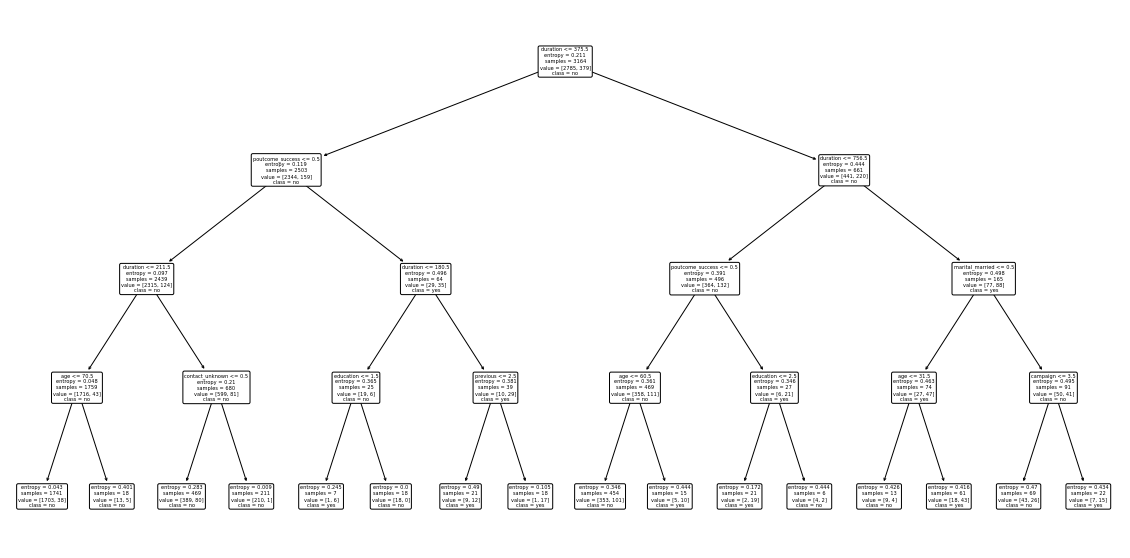

In [21]:
plt.figure(figsize=(20,10))

plot_tree(tree_classifier, feature_names=X_train.columns, class_names=['no', 'yes'], rounded=True)
plt.show()

<h3>Random Forest Model</h3>

In [24]:
rf_classifier = RandomForestClassifier(criterion="gini", random_state = 100, max_depth = 4, min_samples_leaf = 5)

rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
evaluate(y_test, y_pred_rf)


Confusion Matrix: 
[[1208    7]
 [ 124   18]]
Accuracy : 
90.34635224760501
Report : 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1215
           1       0.72      0.13      0.22       142

    accuracy                           0.90      1357
   macro avg       0.81      0.56      0.58      1357
weighted avg       0.89      0.90      0.87      1357



In [25]:
feature_imp_rf = pd.Series(rf_classifier.feature_importances_, index = X_train.columns).sort_values(ascending=False)[:10]
print(feature_imp_rf)

duration            0.278202
poutcome_success    0.274796
pdays               0.089455
age                 0.054935
job                 0.053166
contact_unknown     0.049316
balance             0.035845
contact_cellular    0.028523
day                 0.025520
month               0.018755
dtype: float64


<h3>XGBoost</h3>


In [29]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1, max_depth=4)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
evaluate(y_test, y_pred_xgb)

Confusion Matrix: 
[[1186   29]
 [  86   56]]
Accuracy : 
91.52542372881356
Report : 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1215
           1       0.66      0.39      0.49       142

    accuracy                           0.92      1357
   macro avg       0.80      0.69      0.72      1357
weighted avg       0.90      0.92      0.91      1357



In [31]:
feature_imp_xgb = pd.Series(xgb_classifier.feature_importances_, index = X_train.columns).sort_values(ascending=False)[:10]
print(feature_imp_xgb)

poutcome_success    0.147335
duration            0.125556
contact_unknown     0.113358
housing             0.054215
loan                0.052956
previous            0.043467
default             0.042999
marital_married     0.042438
month               0.042307
job                 0.040435
dtype: float32


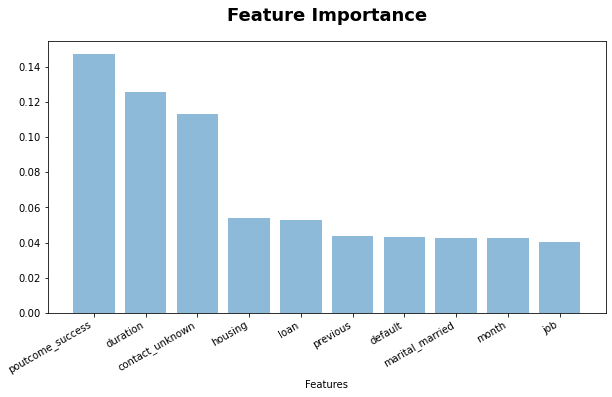

In [46]:
plt.figure(figsize=(10,5))

y_pos = np.arange(len(feature_imp_xgb))
plt.bar(y_pos, feature_imp_xgb, align='center', alpha=0.5)
plt.xticks(y_pos, feature_imp_xgb.index, rotation=30, ha='right')
plt.xlabel('Features')
plt.title("Feature Importance", weight='bold', fontsize=18, pad=20)
plt.show()